## Imports and setup of SH API

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import box
from datetime import datetime
import rasterio as rs
from rasterio.plot import show
from osgeo import gdal
import tifffile as tiff
import os
from PIL import Image
from sklearn import metrics 

# mandatory imports
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from xcube.core.geom import mask_dataset_by_geometry
import rioxarray
import xarray as xr

# Utilities for notebook visualization
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 20,8

In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In [4]:
get_data_store_params_schema('sentinelhub')

In [5]:
store = new_data_store('sentinelhub', num_retries=400)

In [6]:
list(store.get_data_ids())

['S2L1C', 'S1GRD', 'S2L2A', 'DEM']

In [7]:
store.describe_data('S2L2A')

---

## Importing and exploring the landslide inventory

In [8]:
landslide_inventory = pd.read_csv('inventory.csv')

In [9]:
gdf = gpd.GeoDataFrame(
    landslide_inventory, geometry=gpd.points_from_xy(landslide_inventory.longitude, landslide_inventory.latitude), crs="EPSG:4326"
)

<Axes: >

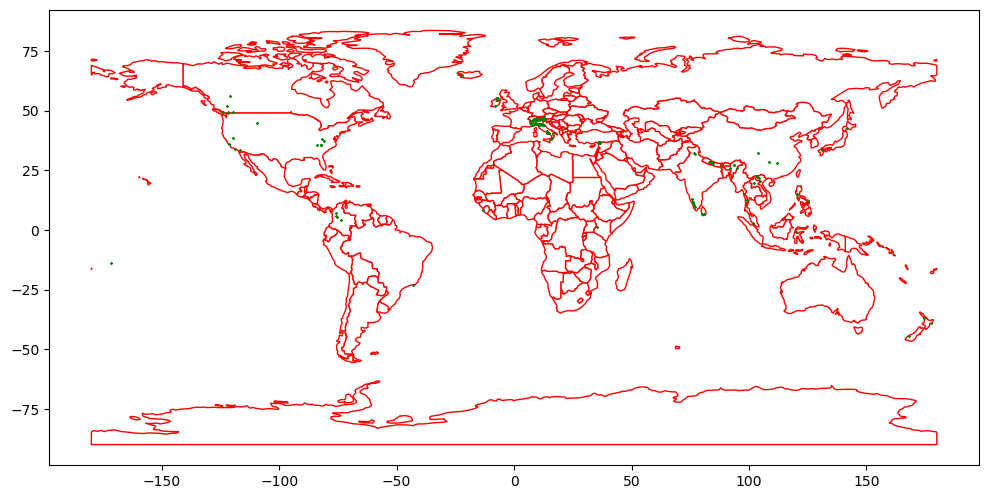

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='red', figsize = (12,12))
gdf.plot(ax = base, marker='*', color='green', markersize=1)

### API EXTRACTION AND VISUALIZATION OF ONE OF THE EVENTS FROM THE .CSV FILE

In [11]:
# --- import the landslide inventory as pandas DataFrame ---
landslide_inventory = pd.read_csv('inventory.csv')

i = 36 # choosing the event for which to retrieve the images
x = 0.01 # choosing the buffer around the location of the event (0.01 ~= 1 km)

# --- defining the bounding box ---
bbox = [landslide_inventory.iloc[i].longitude - x, landslide_inventory.iloc[i].latitude - x,
        landslide_inventory.iloc[i].longitude + x, landslide_inventory.iloc[i].latitude + x]

# --- defining the time ranges ---
time_range_pre = (landslide_inventory.iloc[i]["pre1"], landslide_inventory.iloc[i]["pre1"])
time_range_post = (landslide_inventory.iloc[i]["post1"], landslide_inventory.iloc[i]["post1"])

dataset_pre = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00009,  #~= 10m
                          time_range=time_range_pre, 
                          time_period='1D',
                          tile_size= [1024, 1024])

dataset_post = store.open_data('S2L2A', 
                          variable_names=['B02', 'B03', 'B04', 'B08', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00009, #~= 10m
                          time_range=time_range_post, 
                          time_period='1D',
                          tile_size= [1024, 1024])


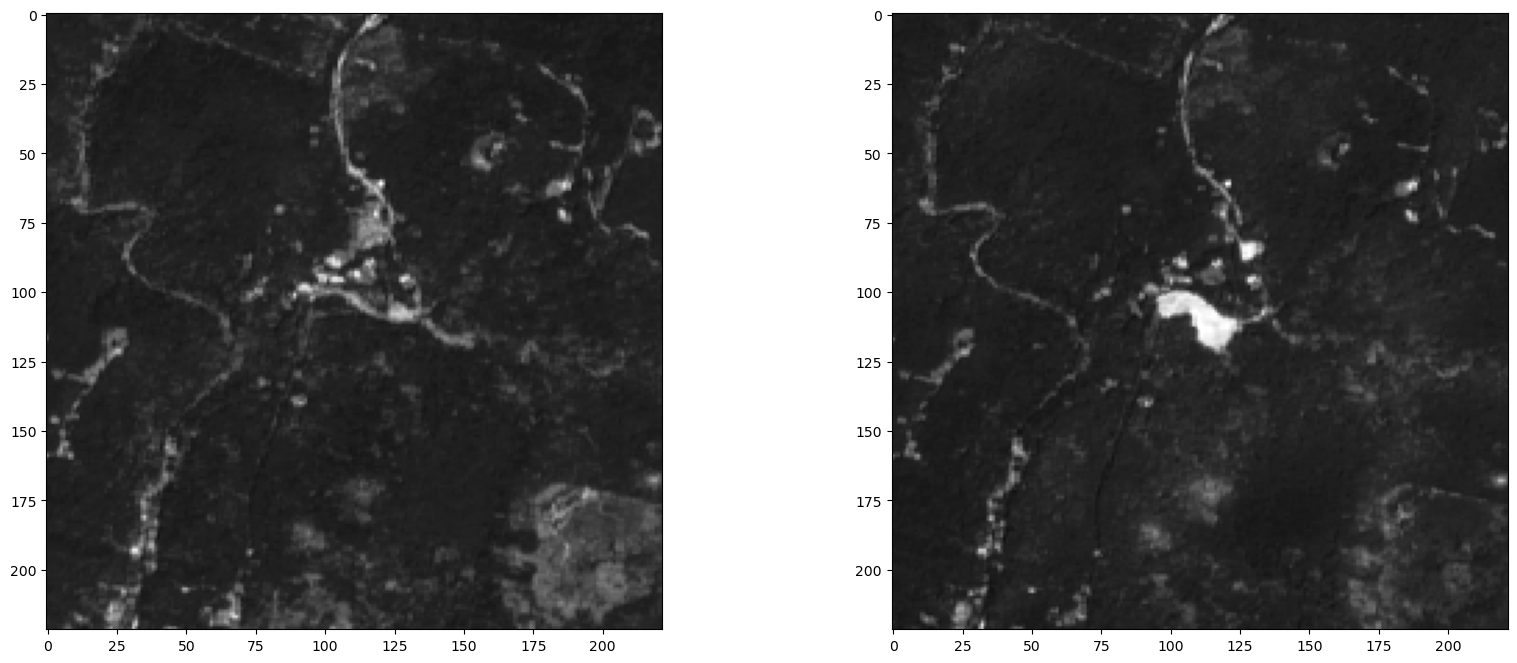

In [12]:
f, axarr = plt.subplots(1,2)
pre = dataset_pre.B04[0]
post = dataset_post.B04[0]

axarr[0].imshow(pre, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(post, vmin=0, vmax=0.2, cmap='Greys_r')

---

## Retrieving the images through SH API, DFs creation, cloud masking, saving to NetCDF

In [25]:
landslide_list = []
ident = 0
x = 0.01

for index, row in landslide_inventory.iterrows():
    event_date = row.event_date
    bbox = [row.longitude - x, row.latitude - x, row.longitude + x, row.latitude + x]
    poly = box(bbox[0], bbox[1], bbox[2], bbox[3])
    time_range_pre = (row.pre2, row.pre2)
    time_range_post = (row.post1, row.post1)
    
    dataset_pre = store.open_data('S2L2A', 
                          variable_names=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_pre, 
                          time_period='1D',
                          tile_size= [1024, 1024])
   
    dataset_post = store.open_data('S2L2A', 
                          variable_names=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_post, 
                          time_period='1D',
                          tile_size= [1024, 1024])
   
    landslide_list.append(
        {
            'T1':dataset_pre,
            'T2':dataset_post, 
        }
    )
    ident = ident + 1

In [26]:
landslide_df = pd.DataFrame(landslide_list)

In [27]:
landslide_df

,T1,T2
0,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
1,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
2,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
3,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
4,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
...,...,...
169,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
170,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
171,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."
172,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ..."


### creating a DataFrame with only the events from the validation set

In [16]:
GT_landslide_list = []
event_no = [2,36,41,42,61,75,108,121,125,128,135,140,155,158,164,171,173]

In [28]:
GT_landslide_list = []
event_no = [2,36,41,42,61,75,108,121,125,128,135,140,155,158,164,171,173]
x = 0.01
for index in event_no:
    event = landslide_inventory.iloc[index]
    event_date = event.event_date
    bbox = [event.longitude - x, event.latitude - x, event.longitude + x, event.latitude + x]
    poly = box(bbox[0], bbox[1], bbox[2], bbox[3])
    time_range_pre2 = (event.pre2, event.pre2)
    time_range_post = (event.post1, event.post1)
    
    dataset_pre2 = store.open_data('S2L2A', 
                          variable_names=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_pre2, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    
    dataset_post = store.open_data('S2L2A', 
                          variable_names=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'CLM'], 
                          bbox=bbox, 
                          spatial_res=0.00001, 
                          time_range=time_range_post, 
                          time_period='1D',
                          tile_size= [1024, 1024])
    
    GT_landslide_list.append(
        {
            'T1':dataset_pre2,
            'T2':dataset_post,
            'id':index
        }
    )
    
GT_landslide_df = pd.DataFrame(GT_landslide_list)
GT_landslide_df

,T1,T2,id
0,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",2
1,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",36
2,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",41
3,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",42
4,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",61
5,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",75
6,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",108
7,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",121
8,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",125
9,"[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...","[B01, B02, B03, B04, B05, B06, B07, B08, B09, ...",128


In [21]:
for index, row in landslide_df.iterrows():
    mask = row.T1.CLM[0] + row.T2.CLM[0]
    
    row.T1.CLM[0] = mask
    row.T2.CLM[0] = mask

In [60]:
x = ma.array(B02, mask=mask, fill_value = 0)
x.filled([None])

array([[0.0341, 0.0341, 0.0341, ..., 0.0699, 0.078 , 0.078 ],
       [0.0341, 0.0341, 0.0341, ..., 0.0699, 0.078 , 0.078 ],
       [0.0341, 0.0341, 0.0341, ..., 0.0799, 0.0848, 0.0848],
       ...,
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]],
      dtype=float32)

In [36]:
print(ile, len(ile))

[1, 6, 11, 18, 22, 26, 30, 38, 39, 42, 66, 67, 76, 77, 79, 85, 90, 91, 92, 93, 94, 105, 106, 110, 112, 117, 118, 132, 133, 139, 146, 149, 151, 152, 154] 35


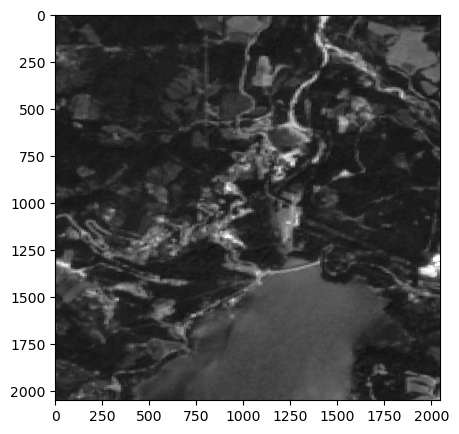

In [57]:
mask = B02 = landslide_df_3.loc[76].post.B02[0]
f, axarr = plt.subplots(1,1)
axarr.imshow(mask, vmin=0, vmax=0.2, cmap='Greys_r')

### Saving the xr.Datasets to NetCDF [do not run]

In [ ]:
for index, row in landslide_df.iterrows():
    pre1 = xr.Dataset(row.pre1.isel(time=0))
    pre2 = xr.Dataset(row.pre2.isel(time=0))
    post = xr.Dataset(row.post.isel(time=0))
    pre1_dir = "NetCDF/pre1_" + str(index) + ".nc"
    pre2_dir = "NetCDF/pre2_" + str(index) + ".nc"
    post_dir = "NetCDF/post_" + str(index) + ".nc"
    pre1.to_netcdf(pre1_dir)
    pre2.to_netcdf(pre2_dir)
    post.to_netcdf(post_dir)

---

## Exploring the two created DF

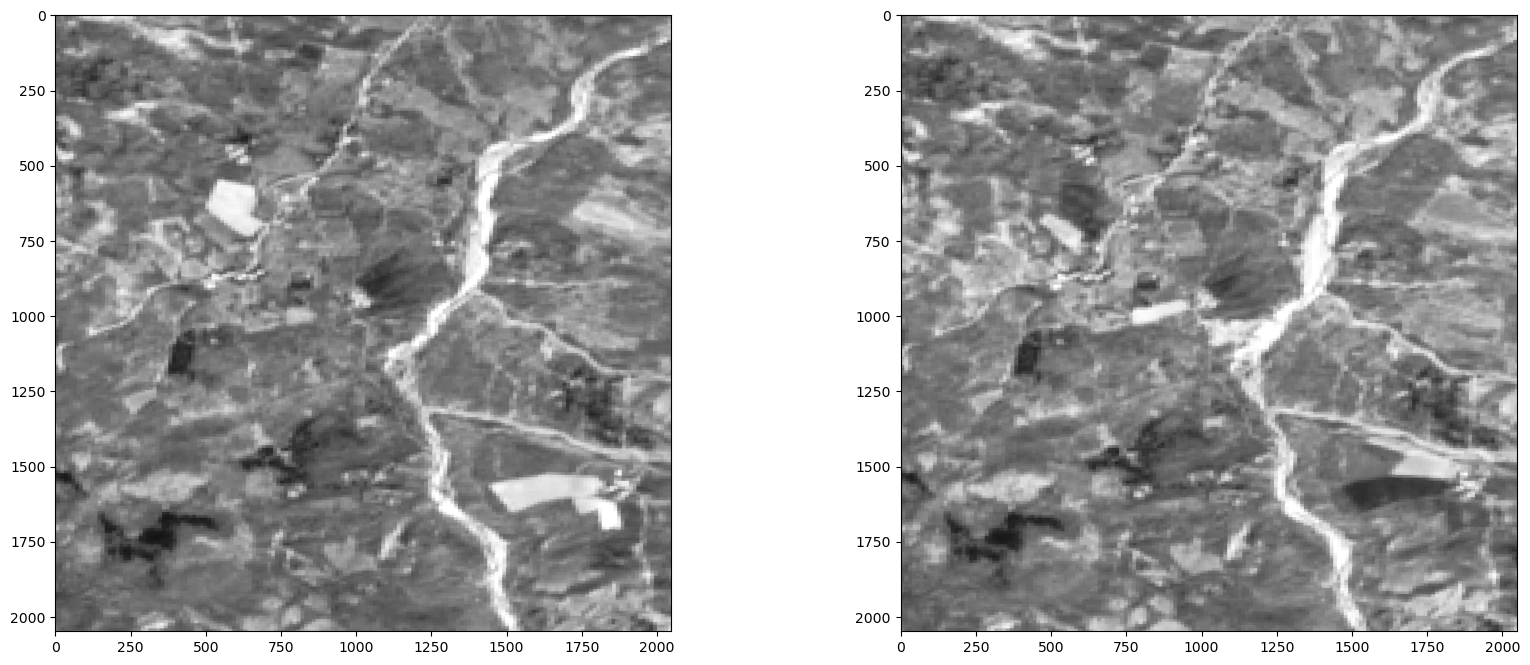

In [19]:
i = 108
f, axarr = plt.subplots(1,2)
img1 = landslide_df.iloc[i].T1.B04[0]
img2 = landslide_df.iloc[i].T2.B04[0]
axarr[0].imshow(img1, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(img2, vmin=0, vmax=0.2, cmap='Greys_r')

---

## Change map calculation using differential imaging and threshold analysis

[]

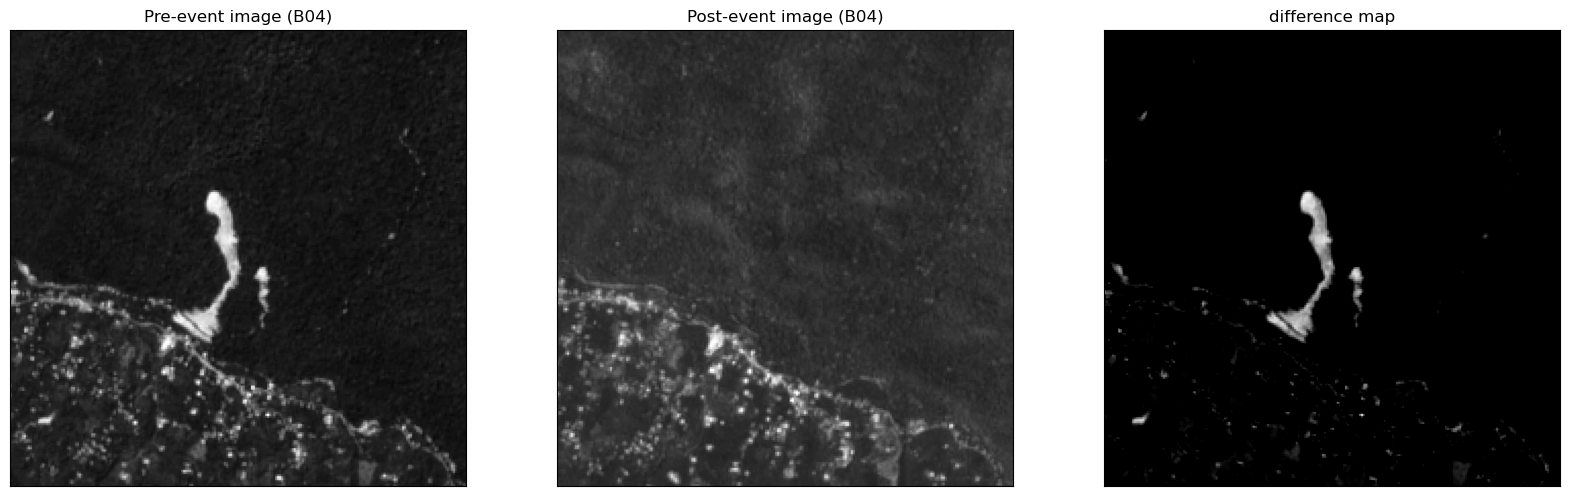

In [32]:
T1 = GT_landslide_df.iloc[2].T1
T2 = GT_landslide_df.iloc[2].T2

pre_event_image = T1["B04"][0]
post_event_image = T2["B04"][0]

change_map = post_event_image - pre_event_image

threshold = 0.05 # Example threshold value
binary_change_map_l = (change_map > threshold).astype(int)

f, axarr =  plt.subplots(1,3)
axarr[0].imshow(post_event_image, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0].set_title("Pre-event image (B04)")
axarr[0].xaxis.set_tick_params(labelbottom=False)
axarr[0].yaxis.set_tick_params(labelleft=False)
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(pre_event_image, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].set_title("Post-event image (B04)")
axarr[1].xaxis.set_tick_params(labelbottom=False)
axarr[1].yaxis.set_tick_params(labelleft=False)
axarr[1].set_xticks([])
axarr[1].set_yticks([])

axarr[2].imshow(change_map, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2].set_title("difference map")
axarr[2].xaxis.set_tick_params(labelbottom=False)
axarr[2].yaxis.set_tick_params(labelleft=False)
axarr[2].set_xticks([])
axarr[2].set_yticks([])

[]

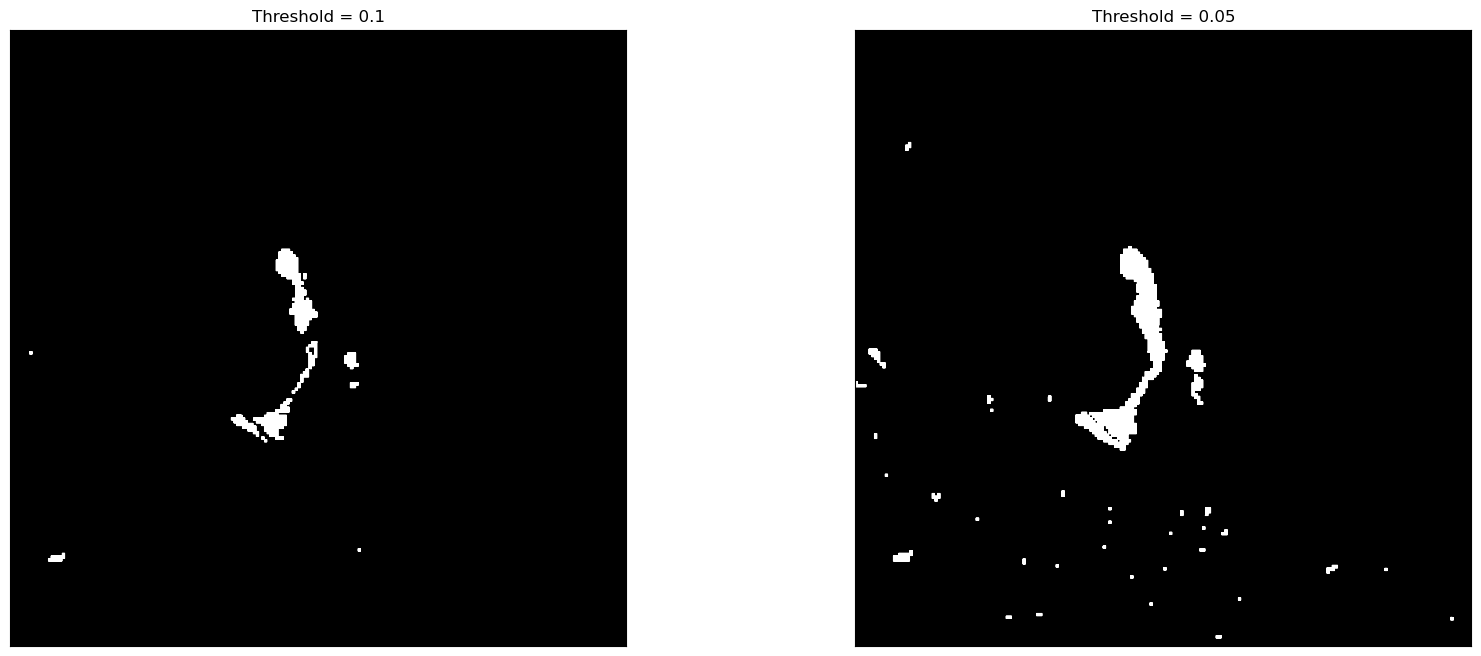

In [33]:
threshold = 0.05 # Example threshold value
binary_change_map_5 = (change_map > 0.05).astype(int)
binary_change_map_1 = (change_map > 0.1).astype(int)

f, axarr =  plt.subplots(1,2)
axarr[0].imshow(binary_change_map_1, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0].set_title("Threshold = 0.1")
axarr[0].xaxis.set_tick_params(labelbottom=False)
axarr[0].yaxis.set_tick_params(labelleft=False)
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(binary_change_map_5, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].set_title("Threshold = 0.05")
axarr[1].xaxis.set_tick_params(labelbottom=False)
axarr[1].yaxis.set_tick_params(labelleft=False)
axarr[1].set_xticks([])
axarr[1].set_yticks([])

Text(0.5, 1.0, 'B8A')

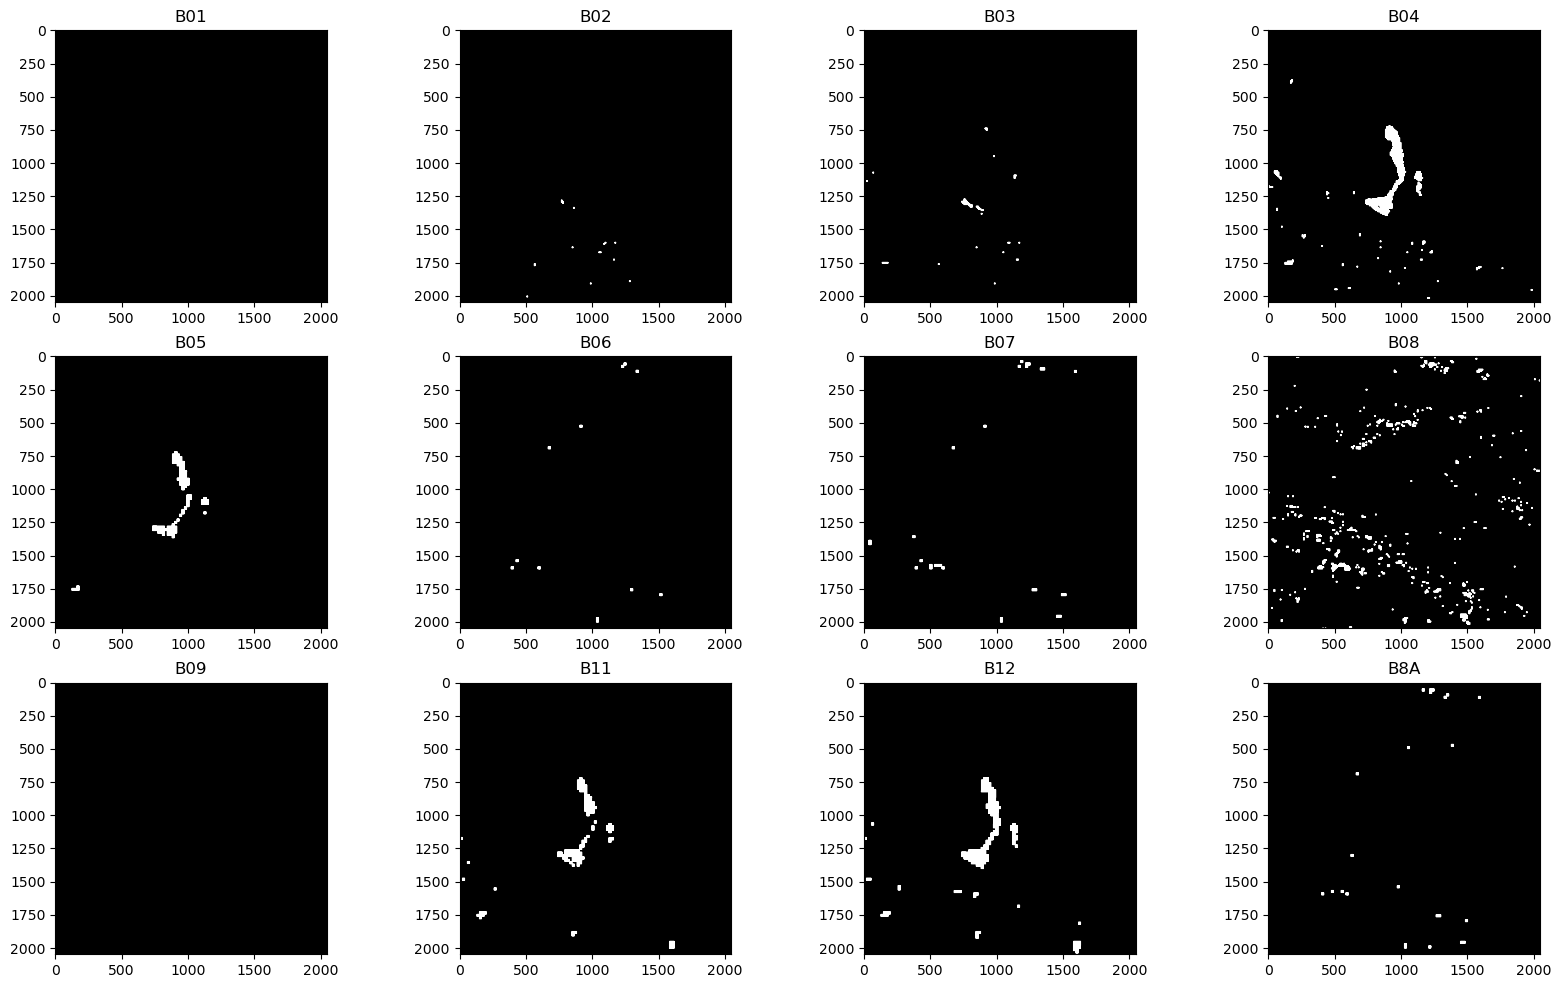

In [38]:
i = 41
th_B01_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B01/"+str(i)+".png")
th_B02_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B02/"+str(i)+".png")
th_B03_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B03/"+str(i)+".png")
th_B04_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B04/"+str(i)+".png")
th_B05_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B05/"+str(i)+".png")
th_B06_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B06/"+str(i)+".png")
th_B07_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B07/"+str(i)+".png")
th_B08_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B08/"+str(i)+".png")
th_B09_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B09/"+str(i)+".png")
th_B11_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B11/"+str(i)+".png")
th_B12_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B12/"+str(i)+".png")
th_B8A_2 = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/threshold_B8A/"+str(i)+".png")

f, axarr = plt.subplots(3,4, figsize=(20,12))
axarr[0][0].imshow(th_B01_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][0].set_title('B01')

axarr[0][1].imshow(th_B02_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][1].set_title('B02')

axarr[0][2].imshow(th_B03_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][2].set_title('B03')

axarr[0][3].imshow(th_B04_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[0][3].set_title('B04')

axarr[1][0].imshow(th_B05_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][0].set_title('B05')

axarr[1][1].imshow(th_B06_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][1].set_title('B06')

axarr[1][2].imshow(th_B07_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][2].set_title('B07')

axarr[1][3].imshow(th_B08_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1][3].set_title('B08')

axarr[2][0].imshow(th_B09_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][0].set_title('B09')

axarr[2][1].imshow(th_B11_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][1].set_title('B11')

axarr[2][2].imshow(th_B12_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][2].set_title('B12')

axarr[2][3].imshow(th_B8A_2, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[2][3].set_title('B8A')

### creating the CM to .tif [do not run]

In [57]:
for band in landslide_df.iloc[1].T1.data_vars:
    for i in range(1):
        pre_event_image = landslide_df.iloc[i].T1[band][0]
        post_event_image = landslide_df.iloc[i].T2[band][0]

        change_map = post_event_image - pre_event_image
        threshold = 0.1  # Example threshold value
        
        binary_change_map = (change_map > threshold).astype(int)
        path = "DATA/DIFFERENTIAL_THRESHOLDING/thresholds/threshold_"+ band +"/" + str(i) + ".tif"
        binary_change_map.rio.to_raster(path)

### loading and visualizing the ground truth next to the change map geerated by differential threshold analysis

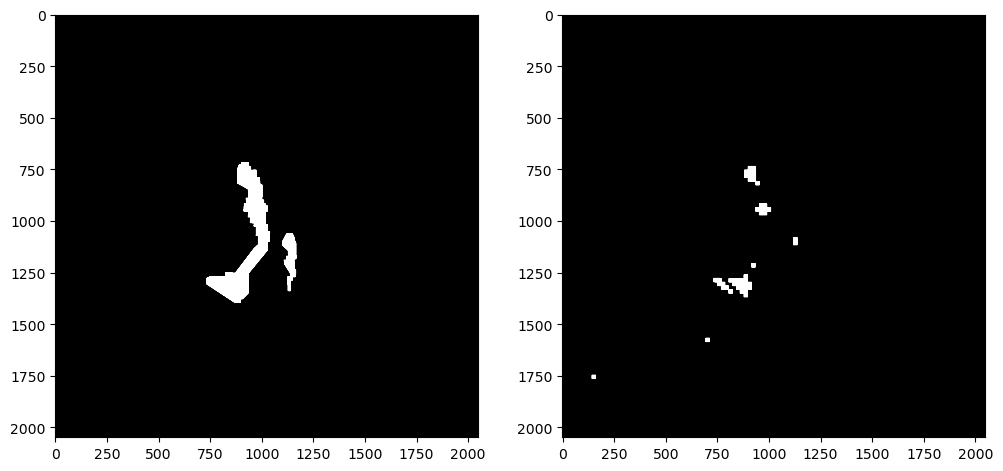

In [63]:
i = 41
GT = tiff.imread("DATA/GT/GT_TIF/GT_" + str(i) + ".tif")
CM_pred = Image.open("DATA/DIFFERENTIAL_THRESHOLDING/thresholds/threshold_B12/" + str(i) + ".png")

f, axarr = plt.subplots(1,2, figsize=(12,10))
axarr[0].imshow(GT, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(CM_pred, vmin=0, vmax=0.2, cmap='Greys_r')

---

### saving the GT annotations also as .png and transforming DL preds in range [0, 1] [do not run]

In [119]:
path = os.listdir('DATA/GT')
for event in path:
    if event[0] == 'G':
        path_out = 'DATA/GT_PNG/' + event[:-4] + '.png'
        path_in = 'DATA/GT/' + event
        image = tiff.imread(path_in)
        #image = image[:,:,:3]
        im = Image.fromarray((image).astype(np.uint8))
        im.save(path_out)

___

## I'm working on the deep learning inference of CM on Google Colab

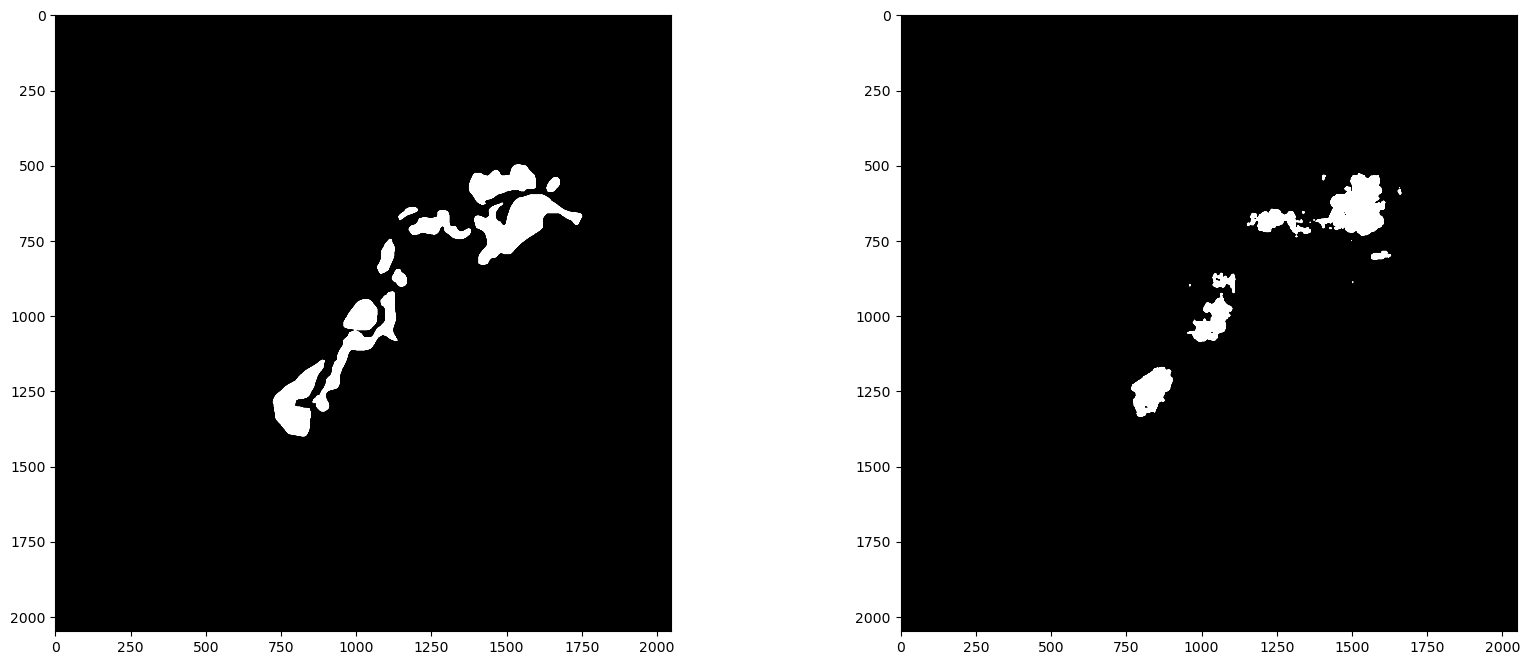

In [64]:
GT_dl = Image.open("DATA/GT/GT_PNG/GT_173.png")
CM_pred_dl = Image.open("DATA/BIT/BIT_PRED/173.png")

f, axarr = plt.subplots(1,2)
axarr[0].imshow(GT_dl, vmin=0, vmax=0.2, cmap='Greys_r')
axarr[1].imshow(CM_pred_dl, vmin=0, vmax=0.2, cmap='Greys_r')

## BBOXing the BIT_PRED and the GT image patches

In [65]:
BBOXs = {
    "2" : (625, 650, 1260, 1275),
    "36" : (850, 780, 1220, 1160),
    "41" : (730, 710, 1170, 1400),
    "42": (940, 1000, 1300, 1400),
    "61" : (937, 995, 1211, 1160),
    "75" : (970, 790, 1130, 1180),
    "108" : (995, 1005, 1250, 1110),
    "121" : (1110, 740, 1222, 1135),
    "125" : (400, 810, 1880, 1310),
    "128" : (0, 300, 1680, 1630),
    "135" : (967, 1038, 1033, 1185),
    "140" : (975, 955, 2048, 1160),
    "155" : (0, 850, 2048, 2048),
    "158" : (920, 1014, 1115, 1092),
    "164" : (60, 940, 2048, 2048),
    "171" : (910, 1005, 1417, 1410),
    "173" : (720, 490, 1750, 1410)
}

In [67]:
path = os.listdir('DATA/BIT/BIT_PRED/')
for event in path:
    if event[-1] == 'g':
        print(BBOXs[event[:-4]])

(975, 955, 2048, 1160)
(730, 710, 1170, 1400)
(850, 780, 1220, 1160)
(995, 1005, 1250, 1110)
(967, 1038, 1033, 1185)
(910, 1005, 1417, 1410)
(937, 995, 1211, 1160)
(0, 300, 1680, 1630)
(60, 940, 2048, 2048)
(720, 490, 1750, 1410)
(0, 850, 2048, 2048)
(920, 1014, 1115, 1092)
(940, 1000, 1300, 1400)
(625, 650, 1260, 1275)
(400, 810, 1880, 1310)
(1110, 740, 1222, 1135)
(970, 790, 1130, 1180)


### bboxing [do not run]

In [16]:
path = os.listdir('DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/')
for band in path:
    if band[0] == 't':
        band_path = os.listdir('DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/'+band)
        for img in band_path:
            if img[-1] == 'g':
                img_pred = Image.open('DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005/'+band+"/"+img)

                bbox = BBOXs[img[:-4]]
                img_pred_crop = img_pred.crop(bbox)

                img_pred_crop.save('DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005_cropped/'+band+"/"+img)

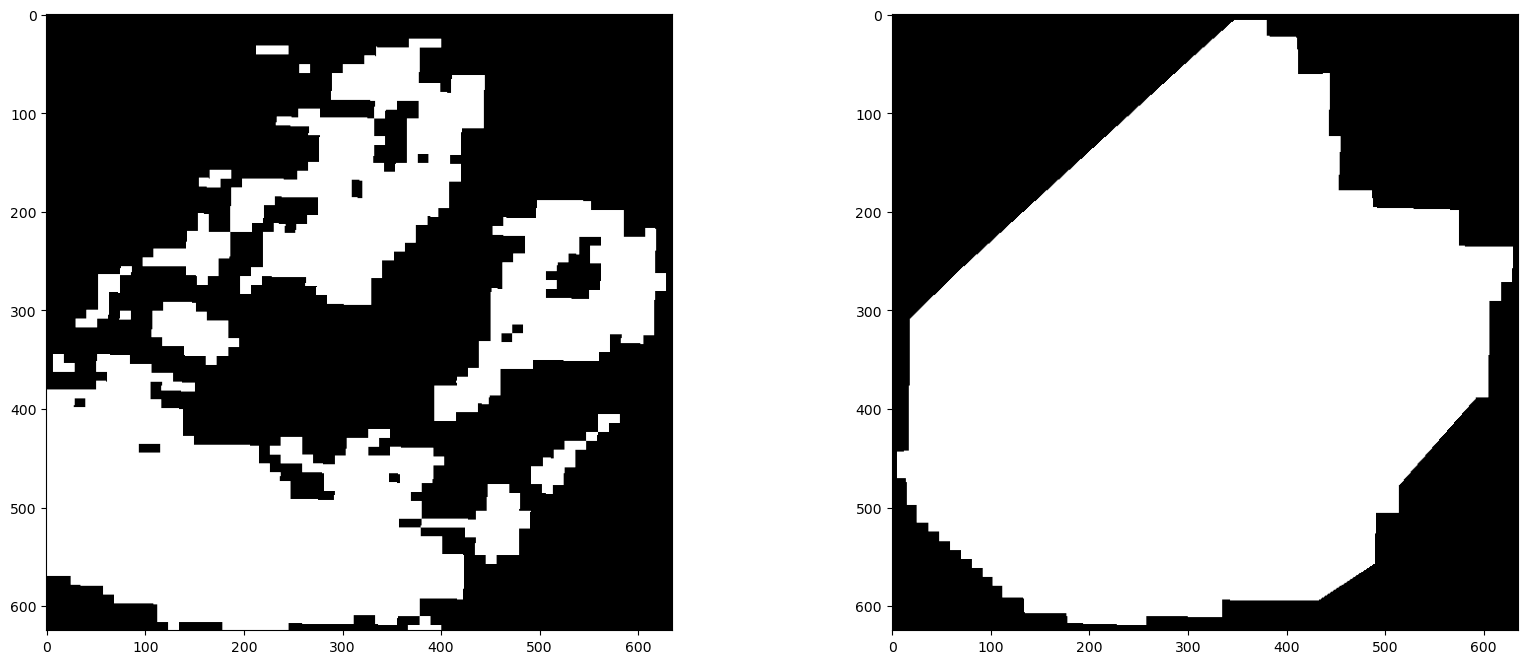

In [68]:
TH = Image.open('DATA/DIFFERENTIAL_THRESHOLDING/thresholds_005_cropped/threshold_B04/2.png')
GT = Image.open('DATA/GT/GT_PNG_cropped/2.png')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(TH, cmap='Greys_r')
axarr[1].imshow(GT, cmap='Greys_r')

### bboxing [do not run]

In [356]:
path = os.listdir('DATA/BIT/BIT_PRED/')
for event in path:
    if event[-1] == 'g':
        img_pred = Image.open('DATA/BIT/BIT_PRED/'+event)
        img_gt = Image.open('DATA/GT/GT_PNG/GT_'+event)
        
        bbox = BBOXs[event[:-4]]
        img_pred_crop = img_pred.crop(bbox)
        img_gt_crop = img_gt.crop(bbox)
        
        img_pred_crop.save('DATA/BIT/BIT_PRED_cropped/'+event)
        img_gt_crop.save('DATA/GT/GT_PNG_cropped/'+event)

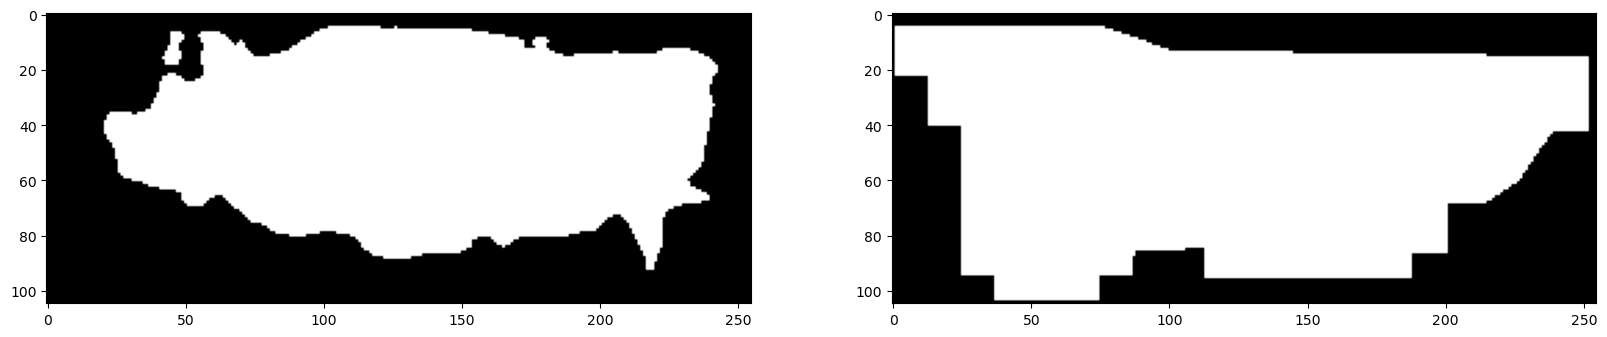

In [70]:
BIT = Image.open('DATA/BIT/BIT_PRED_cropped/108.png')
GT = Image.open('DATA/GT/GT_PNG_cropped/108.png')

f, axarr = plt.subplots(1,2)
axarr[0].imshow(BIT, cmap='Greys_r')
axarr[1].imshow(GT, cmap='Greys_r')

### CDRL: import results, resize, transform, calculate metrics [do not run]

In [10]:
path = os.listdir('DATA/CDRL/CDRL_SA_')
for event in path:
    if event[-1] == 'g':
        path_out = 'DATA/CDRL_SA_27_binary/' + event[:-4] + '.png'
        path_in = 'DATA/CDRL_SA_27/' + event
        image = Image.open(path_in)
        image_resize = image.resize((2048, 2048))
        binary_image = np.any(np.asarray(image_resize) > 0, axis=2).astype(np.uint8)
        binary_image = Image.fromarray(binary_image)
        binary_image.save(path_out)

## TODO: 
    * the thresholds need to be in .png
    * create also the GT for no landslide and see how the changes compare (?)
    * think about what's next after the inference in DL
    * png images - should be of better quality
    * OutOfMemoryError handling